# *Fake News Predictor*
        -> With the help of Logistic Regression I've build a model to predict whether the news is fake or not
        -> Though Machine only understands numeric data we converted all the textual data from our dataset in numeric for metrix with
            the help of TfidfVectorizer
    
<br><br>

In [6]:
import re                                                       # regular experesion library 
import numpy as np
import pandas as pd
from nltk.corpus import stopwords                               # will stop words which doesn't hold much value to paragraph (eg. where, what etc...)
from nltk.stem.porter import PorterStemmer                      # will return text with removed prefix and suffix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split            # will used to split data for tain and test
from sklearn.feature_extraction.text import TfidfVectorizer     # will convert text into feature vectors

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rpirt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## About the Dataset
        1. id       : unique id for news article
        2. title    : the title of a news article
        3. author   : author of the news article
        4. text     : the text of the article, could be incomplete
        5. label    : a label that marks whether the news article is real or fake 

                1   : Fake News
                0   : Real News

In [8]:
# words which we have to ignore later on this project
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<br><br>
### Data Pre-processing

In [13]:
news_dataset = pd.read_csv("../Data/train.csv")

In [14]:
news_dataset.shape

(20800, 5)

In [15]:
news_dataset.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


<br><br>
#### Counting the number of missing values

In [16]:
news_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

<br><br>
#### replacing null values with empty string

In [17]:
news_dataset = news_dataset.fillna('')

<br><br>
#### mergin author and title column

In [19]:
news_dataset["content"] = news_dataset["author"] + ' ' + news_dataset["title"]
news_dataset["content"]

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object

<br><br>
#### seperating data and label

In [20]:
X = news_dataset.drop(columns="label", axis=1)
Y = news_dataset["label"]

In [21]:
print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

<br><br>
#### Stemming
        -> It is the process of reducing a word to its Root word(removing prefix and suffix)
        -> eg. actor, actress, acting   ->  act
        -> Once data is reduced to its root words we can apply feature vactor to convert text into numeric type and feed it to model 

In [22]:
port_stem = PorterStemmer()

In [25]:
def stemming(content):
    # will exlclude everything other then text from content and replace anything other than alphabets with space
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    # will convert all the alphabets in content in smaller case
    stemmed_content = stemmed_content.lower()
    # will split each word from string to list for ML
    stemmed_content = stemmed_content.split()
    # stemming/removing prefix ans suffix to only those words which are not stopwords(which are mentioned above)
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    # will join it to make string again
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [38]:
# below code will apply stemming function to each rows of content column and assign to content column itself
news_dataset["content"] = news_dataset["content"].apply(stemming)

In [39]:
print(news_dataset["content"])

0        darrel lucu hou dem aid even see comey letter ...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exerci b...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [40]:
# seperating the data and label
X = news_dataset["content"].values
Y = news_dataset["label"].values

In [41]:
print(X)

['darrel lucu hou dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exerci balkan'
 'david swanson keep f aliv']


In [42]:
print(Y)

[1 0 1 ... 0 1 1]


<br><br>
#### Converting the textual data to numeric data

In [43]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [44]:
print(X)

  (0, 15553)	0.28485063562728646
  (0, 13348)	0.2565896679337957
  (0, 8822)	0.3635963806326075
  (0, 8546)	0.29212514087043684
  (0, 7612)	0.24785219520671603
  (0, 6930)	0.21874169089359144
  (0, 4917)	0.233316966909351
  (0, 3759)	0.2705332480845492
  (0, 3567)	0.3598939188262559
  (0, 2933)	0.2468450128533713
  (0, 2464)	0.3676519686797209
  (0, 263)	0.27010124977708766
  (1, 16656)	0.3025156488372128
  (1, 6744)	0.19152496072048605
  (1, 5440)	0.7186013955384664
  (1, 3535)	0.2653147533915268
  (1, 2790)	0.19208753385709676
  (1, 2206)	0.36915639258038363
  (1, 1877)	0.15614790568229528
  (1, 1481)	0.2957471154505952
  (2, 15478)	0.41544962664721613
  (2, 9532)	0.49351492943649944
  (2, 5903)	0.3474613386728292
  (2, 5326)	0.3866530551182615
  (2, 3072)	0.46097489583229645
  :	:
  (20797, 12998)	0.2483705036831893
  (20797, 12227)	0.27276402145717243
  (20797, 12022)	0.24790022252744132
  (20797, 10216)	0.0804189541935242
  (20797, 9500)	0.17463635692029988
  (20797, 9431)	0.29394

<br><br>
#### Splitting the dataset for training and testing

In [47]:
# here test_size means test will have 20% of data for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

<br><br>
#### Training the model : Logistic Regression

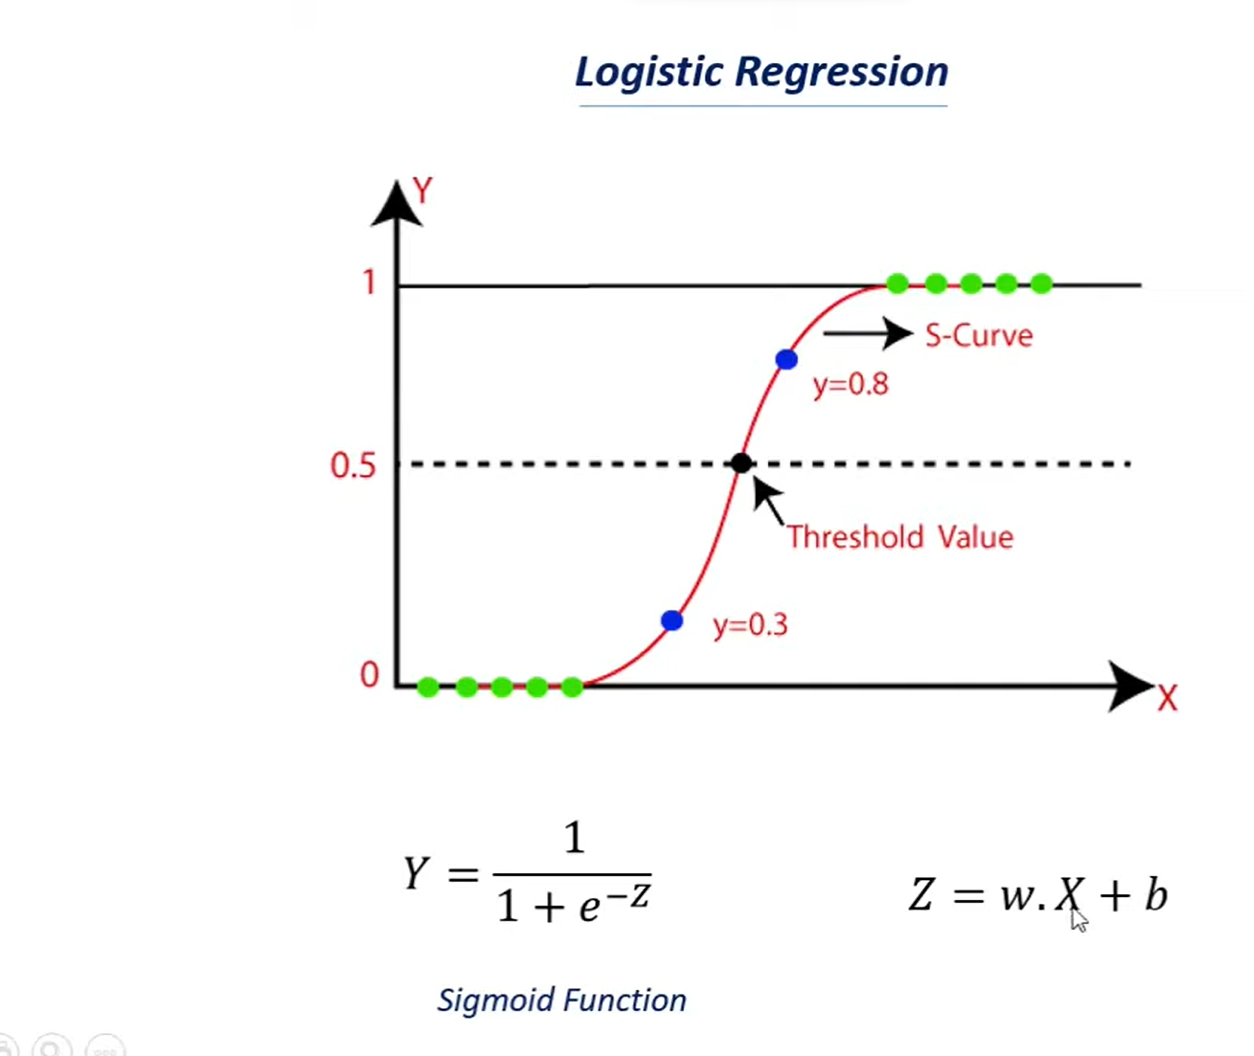

    Here : 
        X : input features
        Y : Prediction Probability
        w : weights
        b : bias

In [48]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

<br><br>
#### Evaluation

<br><br>
##### accuracy score

In [49]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [51]:
print(f"Accuracy score of training data : {training_data_accuracy}")

Accuracy score of training data : 0.9866586538461538


In [52]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [53]:
print(f"Accuracy score of test data : {test_data_accuracy}")

Accuracy score of test data : 0.9790865384615385


<br><br>
#### Make a Predictive system

In [63]:
X_new = X_test[0]
prediction = model.predict(X_new)
print(prediction)

if prediction[0] == 0:
    print("The news is real")
else: 
    print("The news is fake")

    

[1]
The news is fake
